In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}')

df = pd.read_csv('../dados_tratados/combinado/Piratininga/Piratininga_tratado_combinado.csv',
                 usecols=['PM2.5', 'Data e Hora'])
df.dropna(inplace=True)
df.index = pd.to_datetime(df['Data e Hora'], format='%Y-%m-%d %H:%M:%S')
train_dates = pd.to_datetime(df['Data e Hora'], format='%Y-%m-%d %H:%M:%S')

df['Data e Hora'] = pd.to_datetime(df['Data e Hora'])
df['hour'] = df['Data e Hora'].dt.hour
df['minute'] = df['Data e Hora'].dt.minute
df['year'] = df['Data e Hora'].dt.year
df['month'] = df['Data e Hora'].dt.month
df['day'] = df['Data e Hora'].dt.day
df['day_of_week'] = df['Data e Hora'].dt.dayofweek
df['day_of_year'] = df['Data e Hora'].dt.dayofyear
df['week'] = df['Data e Hora'].dt.isocalendar().week

df.drop('Data e Hora', axis=1, inplace=True)



Using cuda


In [3]:
# Normalizando os dados de PM2.5
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(df['PM2.5'].values.reshape(-1, 1))

df['PM2.5'] = scaled_values

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length), :].astype(np.float32)
        y = data[i + seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


seq_length = 8
X, y = create_sequences(df.values, seq_length)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().reshape(-1, 1)
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float().reshape(-1, 1)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().reshape(-1, 1)

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Epoch 0 train loss: 0.0027345952305992617, val loss: 0.0023725112842210893
Epoch 1 train loss: 0.0026386888495775643, val loss: 0.0023692325534426543
Epoch 2 train loss: 0.002626309121284114, val loss: 0.002400373916519786
Epoch 3 train loss: 0.0026224155942595256, val loss: 0.0023510471357278736
Epoch 4 train loss: 0.0026164029376383674, val loss: 0.002349596111244893
Epoch 5 train loss: 0.002578248974506048, val loss: 0.002334897680429916
Epoch 6 train loss: 0.002553446968606138, val loss: 0.0023204492840183076
Epoch 7 train loss: 0.0025631913344133024, val loss: 0.0023525905961093558
Epoch 8 train loss: 0.0025525244517639236, val loss: 0.002331741705623059
Epoch 9 train loss: 0.002544304183526968, val loss: 0.0023373623674721056
Epoch 10 train loss: 0.0025356337620294303, val loss: 0.002323107229475661
Epoch 11 train loss: 0.0025304876647766258, val loss: 0.002338491720367464
Epoch 12 train loss: 0.0025208600492604705, val loss: 0.0023480759916302595
Epoch 13 train loss: 0.002515457

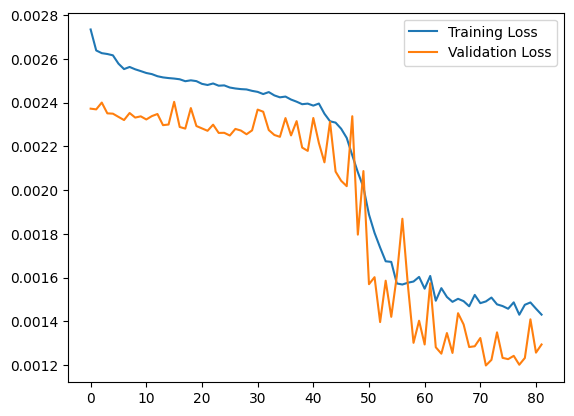

In [4]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, drop_prob=0.2):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions


input_size = X_train.shape[2]
model = LSTM(input_size=input_size, hidden_layer_size=512, num_layers=2, output_size=1).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)


def train_model(model, train_loader, val_loader, loss_function, optimizer, epochs=150, patience=10):
    train_losses = []
    val_losses = []
    best_val_loss = np.inf
    counter = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        # Loop de treinamento
        for seq, labels in train_loader:
            seq, labels = seq.to(device), labels.to(device)
            optimizer.zero_grad()
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
            train_loss += single_loss.item() * seq.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        # Loop de validação
        with torch.no_grad():
            for seq, labels in val_loader:
                seq, labels = seq.to(device), labels.to(device)
                y_pred = model(seq)
                single_loss = loss_function(y_pred, labels)
                val_loss += single_loss.item() * seq.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch} train loss: {train_loss}, val loss: {val_loss}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1

        if counter >= patience:
            print('Early stopping')
            break
    return train_losses, val_losses


train_losses, val_losses = train_model(model, train_loader, val_loader, loss_function, optimizer, epochs=200,
                                       patience=10)

model.load_state_dict(torch.load('best_model.pth'))

model.eval()
test_predictions = []

with torch.no_grad():
    for seq, labels in test_loader:
        seq, labels = seq.to(device), labels.to(device)
        y_pred = model(seq)
        test_predictions.append(y_pred.cpu().numpy())

test_predictions = np.concatenate(test_predictions, axis=0)
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))

mae = np.mean(np.abs(test_predictions - y_test))
mse = np.mean((test_predictions - y_test) ** 2)
mape = np.mean(np.abs(test_predictions - y_test) / np.abs(y_test)) * 100
rmse = np.sqrt(mse)
print("\n\n")
print("Metrics:")
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error: {mape}')

# Plotagem das perdas de treinamento e validação
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()


In [9]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Definição do modelo LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, drop_prob):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(drop_prob)
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

# Função de treinamento e avaliação do modelo
def train_and_evaluate_lstm(hidden_layer_size, num_layers, lr, batch_size, drop_prob):
    model = LSTM(input_size=input_size, hidden_layer_size=hidden_layer_size, num_layers=num_layers, drop_prob=drop_prob, output_size=1).to(device)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

    def train_model():
        model.train()
        for seq, labels in train_loader:
            seq, labels = seq.to(device), labels.to(device)
            optimizer.zero_grad()
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

    def evaluate_model():
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for seq, labels in val_loader:
                seq, labels = seq.to(device), labels.to(device)
                y_pred = model(seq)
                single_loss = loss_function(y_pred, labels)
                val_loss += single_loss.item() * seq.size(0)
        val_loss /= len(val_loader.dataset)
        return val_loss

    epochs = 50
    for epoch in range(epochs):
        train_model()
        val_loss = evaluate_model()
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}")
        
    return val_loss

# Classe PyTorchLSTMRegressor para compatibilidade com Scikit-learn
from sklearn.base import BaseEstimator, RegressorMixin

class PyTorchLSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_layer_size=100, num_layers=2, lr=0.001, batch_size=64, drop_prob=0.2):
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lr = lr
        self.drop_prob = drop_prob
        self.batch_size = batch_size

    def fit(self, X, y):
        self.model = LSTM(input_size=input_size, hidden_layer_size=self.hidden_layer_size, num_layers=self.num_layers, drop_prob=self.drop_prob, output_size=1).to(device)
        self.loss_function = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        train_data = TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).float().reshape(-1, 1))
        self.train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)

        self.train_model()
        return self

    def train_model(self):
        self.model.train()
        for epoch in range(50):
            for seq, labels in self.train_loader:
                seq, labels = seq.to(device), labels.to(device)
                self.optimizer.zero_grad()
                y_pred = self.model(seq)
                single_loss = self.loss_function(y_pred, labels)
                single_loss.backward()
                self.optimizer.step()

    def predict(self, X):
        self.model.eval()
        test_data = torch.from_numpy(X).float()
        test_loader = DataLoader(test_data, batch_size=self.batch_size, shuffle=False)

        predictions = []
        with torch.no_grad():
            for seq in test_loader:
                seq = seq.to(device)
                y_pred = self.model(seq)
                predictions.append(y_pred.cpu().numpy())
        
        predictions = np.concatenate(predictions, axis=0)
        return predictions

# Parâmetros para busca
param_grid = {
    'hidden_layer_size': [64, 128, 256],
    'num_layers': [1, 2, 3],
    'drop_prob': [0.1, 0.2, 0.3],
    'lr': [0.01, 0.001, 0.0001],
    'batch_size': [32, 64, 128]
}

# Usando GridSearchCV com verbose
# grid_search = GridSearchCV(estimator=PyTorchLSTMRegressor(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=3)
# grid_search.fit(X_train.numpy(), y_train.numpy())
# 
# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", -grid_search.best_score_)

# Usando RandomizedSearchCV com verbose
random_search = RandomizedSearchCV(estimator=PyTorchLSTMRegressor(), param_distributions=param_grid, n_iter=10, scoring='neg_mean_squared_error', cv=3, random_state=42, verbose=3)
random_search.fit(X_train.numpy(), y_train.numpy())

print("Best Parameters:", random_search.best_params_)
print("Best Score:", -random_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END batch_size=32, drop_prob=0.1, hidden_layer_size=256, lr=0.0001, num_layers=1;, score=-0.002 total time= 1.9min
[CV 2/3] END batch_size=32, drop_prob=0.1, hidden_layer_size=256, lr=0.0001, num_layers=1;, score=-0.002 total time= 1.9min
[CV 3/3] END batch_size=32, drop_prob=0.1, hidden_layer_size=256, lr=0.0001, num_layers=1;, score=-0.002 total time= 1.9min
[CV 1/3] END batch_size=32, drop_prob=0.1, hidden_layer_size=64, lr=0.0001, num_layers=1;, score=-0.002 total time= 1.5min
[CV 2/3] END batch_size=32, drop_prob=0.1, hidden_layer_size=64, lr=0.0001, num_layers=1;, score=-0.002 total time= 1.5min
[CV 3/3] END batch_size=32, drop_prob=0.1, hidden_layer_size=64, lr=0.0001, num_layers=1;, score=-0.001 total time= 1.5min
[CV 1/3] END batch_size=64, drop_prob=0.3, hidden_layer_size=128, lr=0.0001, num_layers=3;, score=-0.002 total time= 1.2min
[CV 2/3] END batch_size=64, drop_prob=0.3, hidden_layer_size=128, lr=0.000